# Проект: поиск по изображениям

# Описание проекта:

В фотохостинге для профессиональных фотографов "With Sense" пользователи размещают свои фотографии и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д.

Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Компания занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать Proof of Concept — продемонстрировать, что такой проект практически осуществим.

Задача: разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.

На основе лучшей модели можно будет собрать предварительную версию продукта.

# Юридические ограничения

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок должен показываеться дисклеймер: "This image is unavailable in your country in compliance with local laws."

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.

# Блок установки

In [3]:
! pip install -q optuna
! pip install -q transformers
! pip install -U skorch
! pip install -q rich

# Блок импорта библиотек

In [5]:
# таблицы и обработка текста
from rich.console import Console
from math import sqrt
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import os
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import FreqDist
nltk.download('punkt')
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# нейросеть
import torch
import transformers
from torch.nn.utils.rnn import pad_sequence
from tqdm import notebook, tqdm
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, ResNet18_Weights, resnet18
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit
from skorch import NeuralNetRegressor
# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
# Optuna для перебора
import optuna

# константы
RANDOM_SEED = 42
LETTERS = r'[^a-zA-Z\s]'
SPACES = r'([ ])\1+'

BASE_PATH = r"C:\Users\1\Desktop/test_case" # корневая директория
TRAIN_IMAGES = os.path.join(BASE_PATH, 'train_images') # путь к фотографиям для обучения
TEST_IMAGES = os.path.join(BASE_PATH, 'test_images') # путь к фотографиям для тестирования

# настройки блокнота
pd.options.display.max_colwidth = 500
random.seed(RANDOM_SEED)
# экземпляр консоли
console = Console()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Анализ данных

Загрузим данные через конструкцию try-except используя соединение путей os path

In [6]:
# загрузка информации для обучения:
try:
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train_dataset.csv'))
    print('[bold]Информация для обучения:[/bold]')
    display(train_df.head(2))
    display(train_df.info())
except:
    print('Информация для обучения не доступна')

# загрузка информации для тестирования:
try:
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test_queries.csv'), sep='|', index_col='Unnamed: 0')
    console.print('[bold]Информация для тестирования:[/bold]')
    display(test_df.head(2))
    display(test_df.info())
except:
    print('Информация для тестирования не доступна')

# оценка изображений на краудсорсинге
try:
    crowd_annotat = pd.read_csv(os.path.join(BASE_PATH, 'CrowdAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'fraction', 'conf_cnt', 'not_conf_cnt'])
    console.print('[bold]Оценка изображений на краудсорсинге:[/bold]')
    display(crowd_annotat.head(2))
    display(crowd_annotat.info())
except:
    print('Оценка изображений на краудсорсинге не доступна')

# оценка изображений экспертами
try:
    expert_annotat = pd.read_csv(os.path.join(BASE_PATH, 'ExpertAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'exp_1', 'exp_2', 'exp_3'])
    console.print('[bold]Оценка изображений экспертами:[/bold]')
    display(expert_annotat.head(2))
    display(expert_annotat.info())
except:
    print('Оценка изображений экспертами не доступна')

[bold]Информация для обучения:[/bold]


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Информация для тестирования:

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

Оценка изображений на краудсорсинге:

,image,query_id,fraction,conf_cnt,not_conf_cnt
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   fraction      47830 non-null  float64
 3   conf_cnt      47830 non-null  int64  
 4   not_conf_cnt  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Оценка изображений экспертами:

,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

In [7]:
# список всех датасетов
list_df = [train_df, test_df, crowd_annotat, expert_annotat]

## Общая информация

__Пропуски__

In [8]:
print(f'Общее количество пропусков в данных: {sum(sum(col_pas for col_pas in df.isna().sum()) for df in list_df)}')

Общее количество пропусков в данных: 0


__Дубликаты__

In [9]:
print(f'Общее количество дубликатов в данных: {sum(df.duplicated().sum() for df in list_df)}')

Общее количество дубликатов в данных: 0


## Числовые признаки
### crowd_annotat

In [10]:
# статистика для crowd_annotat
console.print('[bold]Статистика для crowd_annotat:[/bold]')
print(crowd_annotat.describe())

Статистика для crowd_annotat:

           fraction      conf_cnt  not_conf_cnt
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000


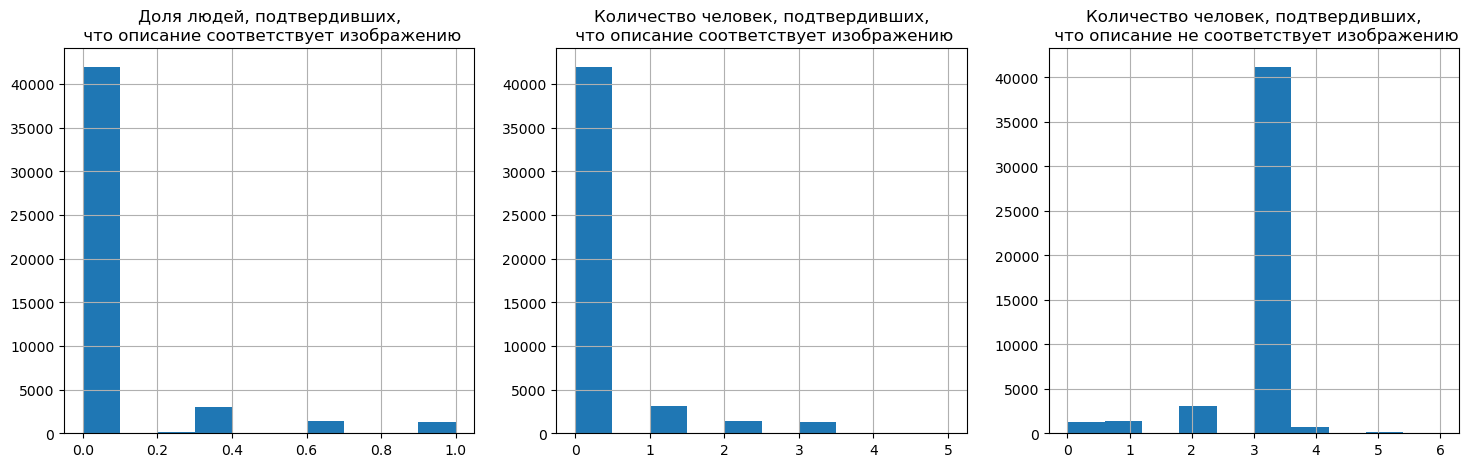

In [11]:
# визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

crowd_annotat['fraction'].hist(ax=axes[0])
axes[0].set_title("Доля людей, подтвердивших,\n что описание соответствует изображению")

crowd_annotat['conf_cnt'].hist(ax=axes[1])
axes[1].set_title("Количество человек, подтвердивших,\n что описание соответствует изображению")

crowd_annotat['not_conf_cnt'].hist(ax=axes[2])
axes[2].set_title("Количество человек, подтвердивших,\n что описание не соответствует изображению")

plt.show()

__Анализ общего числа респондентов:__

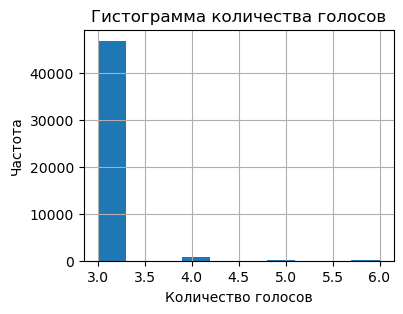

In [12]:
# вычисляем сумму conf_cnt и not_conf_cnt для каждой записи
crowd_annotat['total_votes'] = crowd_annotat['conf_cnt'] + crowd_annotat['not_conf_cnt']

plt.figure(figsize=(4, 3))
crowd_annotat['total_votes'].hist()
plt.title("Гистограмма количества голосов")
plt.xlabel("Количество голосов")
plt.ylabel("Частота")
plt.show()

> Низкая доля подтверждений указывает на то, что пользователи не уверены в соответствии описания изображениям

>Значительный разброс в числе подтверждений и неподтверждений, указывает на несогласие между разными пользовательскими оценками.
>
>Высокое количество неподтверждений может быть вызвано неправильным описанием или изображением.

>Общее число респондентов редко превышает трех человек, это дает основание склоняться к оценке экспертов.

### Числовые признаки в expert_annotat

In [13]:
# статистика для expert_annotat
console.print('[bold]Статистика для expert_annotat:[/bold]')
print(expert_annotat.describe())

Статистика для expert_annotat:

             exp_1        exp_2        exp_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000


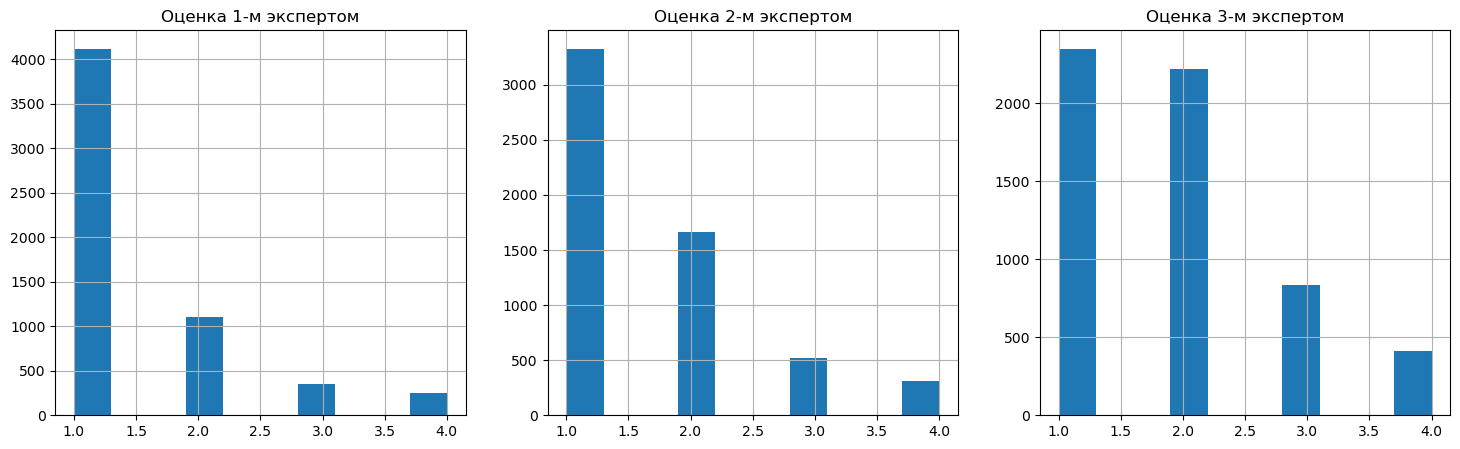

In [14]:
# визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

expert_annotat['exp_1'].hist(ax=axes[0])
axes[0].set_title("Оценка 1-м экспертом")

expert_annotat['exp_2'].hist(ax=axes[1])
axes[1].set_title("Оценка 2-м экспертом")

expert_annotat['exp_3'].hist(ax=axes[2])
axes[2].set_title("Оценка 3-м экспертом")

plt.show()

> Данные от экспертов менее склонны к низким оценкам и имеют меньшую вариабельность.
> В дальнейшей работе, будем использовать именно оценку экспертов.

In [15]:
# фотографии с изображением детей
csv_url = r"C:\Users\1\Desktop/test_case/child.csv"
child = pd.read_csv(csv_url)
display(child.head(2))

,image
0,3767841911_6678052eb6.jpg
1,106490881_5a2dd9b7bd.jpg


__Вывод на экран нескольких фотографий__

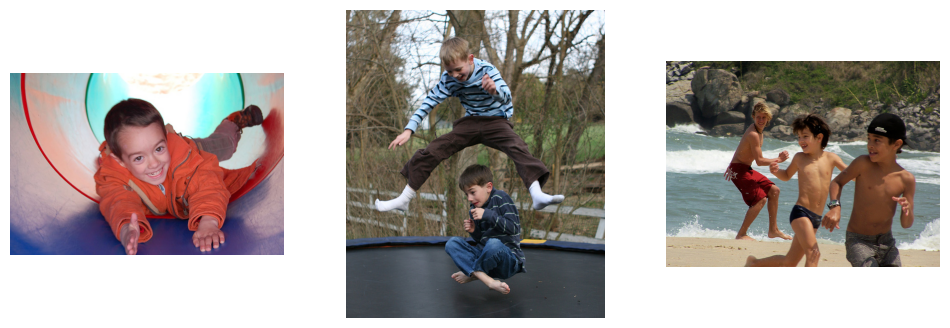

In [16]:
# количество изображений, в выборке
num_images = 3

# выборка
selected_rows = child.sample(n=num_images, random_state=RANDOM_SEED)

# визуализация
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

for i, (index, row) in enumerate(selected_rows.iterrows()):
    image_filename = row['image']
    image_path = os.path.join(TRAIN_IMAGES, image_filename)

    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

__Записи датасета, содержащие изображения детей__

In [17]:
df_child = child.merge(train_df, on='image', how='inner')[['image', 'query_text']]
display(df_child.head(2))

,image,query_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .


__Предобработка текста__

In [18]:
# функция для первичной обработки текста
def clean_text(txt):
    txt = txt.lower() # перевод в нижний регист
    txt = re.sub(LETTERS, ' ', txt) #не буквенные символы меняем на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    return txt

df_child['clean_text'] = df_child['query_text'].apply(clean_text)
display(df_child.head(2))

,image,query_text,clean_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,a dog jumps to catch a red frisbee in the yard
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,a black and white dog prepares to catch a frisbee


__Удаление стоп-слов__

In [19]:
# загрузка стоп-слов для английского языка
english_stopwords = stopwords.words('english')

# функция для удаления стоп-слов и токенизации текста
def stopwords_tokenize(x):
    tokens = word_tokenize(x)
    tokenization = [word for word in tokens if not word in english_stopwords]
    return ' '.join(tokenization)

df_child['clean_text'] = df_child['clean_text'].apply(stopwords_tokenize)
display(df_child.head(2))

,image,query_text,clean_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,dog jumps catch red frisbee yard
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,black white dog prepares catch frisbee


__Лемматизация текста__

In [20]:
# экземпляр WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def penn2morphy(penntag):
    # словарь для соответствия тегов Penn Treebank тегам WordNet.
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]] # соответствующий тег WordNet
    except:
        return 'n' # (существительное) по умолчанию

def lemmatize_text(text):
    # функция принимает на вход строку текста и выполняет лемматизацию
    # возвращается строку из лемматизированных слов
    return ' '.join(lemmatizer.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(text)))

df_child['clean_text'] = df_child['clean_text'].apply(lemmatize_text)
display(df_child.head(2))

,image,query_text,clean_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,dog jump catch red frisbee yard
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,black white dog prepares catch frisbee


__Токенизация и частотный анализ текста__

In [21]:
# токенизация текста
df_child['tokens'] = df_child['clean_text'].apply(lambda x: x.split())
display(df_child.head(2))

,image,query_text,clean_text,tokens
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,dog jump catch red frisbee yard,"[dog, jump, catch, red, frisbee, yard]"
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,black white dog prepares catch frisbee,"[black, white, dog, prepares, catch, frisbee]"


In [22]:
# список всех токенов
tokens_list = [item for sublist in df_child['tokens'].to_list() for item in sublist]
# частотность токенов
freq_dist = FreqDist(tokens_list)

In [23]:
# перевод частотности в датафрейм
freq_df = pd.DataFrame.from_dict(freq_dist, orient='index', columns=['freq'])
# сортировка
freq_df = freq_df.sort_values(by='freq', ascending=False)
# наиболее частые слова
print(freq_df.index[:100])

Index(['dog', 'man', 'two', 'boy', 'girl', 'woman', 'white', 'child', 'young',
       'wear', 'play', 'little', 'stand', 'blue', 'jump', 'red', 'black',
       'water', 'shirt', 'sit', 'people', 'run', 'smile', 'front', 'walk',
       'beach', 'pool', 'swing', 'hold', 'player', 'ball', 'brown', 'look',
       'camera', 'next', 'person', 'group', 'men', 'snow', 'field', 'hat',
       'green', 'basketball', 'near', 'large', 'one', 'building', 'small',
       'three', 'yellow', 'watch', 'slide', 'grass', 'street', 'rid', 'orange',
       'tree', 'rock', 'pink', 'kid', 'another', 'ocean', 'jacket', 'baby',
       'dress', 'crowd', 'pose', 'dirt', 'bike', 'air', 'mouth', 'uniform',
       'soccer', 'catch', 'face', 'background', 'purple', 'park', 'hand',
       'playground', 'sand', 'adult', 'top', 'take', 'sunglass', 'swim',
       'ride', 'table', 'outside', 'city', 'outdoor', 'toddler', 'around',
       'car', 'beside', 'hair', 'dance', 'football', 'strip', 'toy'],
      dtype='object')


__Список слов, относящихся к детям__

In [24]:
child_list = ['boy', 'girl', 'child', 'young', 'baby', 'teenage', 'kid', 'toddler']

> Определен список слов, отпределяющий изображение детей в наборе данных.

## Удаление записей содержащие в описании слова, относящихся к детям.

In [25]:
# функция по обработке текста
def clean_tokenize_text(text):
    text = clean_text(text)
    text = stopwords_tokenize(text)
    text = lemmatize_text(text)
    return text.split()

# функция для поиска слов, относящихся к детям
def child(x):
    if any(i in x for i in child_list): return 'child'
    return 'not_a_child'

In [26]:
# обработка датасета с данными для тренировки
train_df['tokens'] = train_df['query_text'].apply(clean_tokenize_text)
train_df['child'] = train_df['tokens'].apply(child)
display(train_df.head(2))

,image,query_id,query_text,tokens,child
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .,"[young, child, wear, blue, goggles, sit, float, pool]",child
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .,"[young, child, wear, blue, goggles, sit, float, pool]",child


- Отфильтруем датасет, по записям, относяхшихся к детям
- Получим из признака `query_id` список изображений к которым относились данные описания
- Отфильтруем данные для обучения, исключив записи, содержащие изображения, попадающие под юридические ограничения

In [27]:
# список изображений для исключения
exclude_values = train_df[train_df['child'] == 'child']['query_id'].str[:-2].unique()

In [28]:
train = train_df[~train_df['image'].isin(exclude_values)][['image', 'query_id', 'query_text']].copy()

In [29]:
print(f'Исключено {len(train_df)-len(train)} записей, относящиеся к детям')

Исключено 1790 записей, относящиеся к детям


> Исключино 1790 записей, из обучающего датасета, которые, исходя из подготовленного списка слов, могут попадать под юридические ограничения.

#  Подготовка данных к обучению модели
## Векторизация текстового описания
(Bidirectional Encoder Representations from Transformers) представляют собой векторные представления слов и текстов, полученные с использованием модели глубокого обучения BERT. Это одна из наиболее мощных и контекстно-зависимых моделей в области обработки естественного языка.

__Паддинг данных__

In [30]:
tqdm.pandas()

# проверяем доступность MPS
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# инициализация токенизатор, конфигурацию и модель BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model_emb_txt = transformers.BertModel.from_pretrained('bert-base-uncased', config=config).to(device)
# токенизируем текста
tokenized = train['query_text'].progress_apply(lambda x:
                                           tokenizer.encode(x, max_length=512,
                                                            truncation=True, add_special_tokens=True))

padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)

attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

100%|████████████████████████████████████████████████████████████████████████████| 4032/4032 [00:00<00:00, 7680.02it/s]


__Эмбеддинги текста__

In [31]:
# создание эмбедингов
batch_size = 224
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.Tensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            batch_embeddings = model_emb_txt(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

text_features = np.concatenate(embeddings)

# сохранение эмбеддингов в файл
np.save(os.path.join(BASE_PATH, 'text_features.npy'), text_features)

  0%|          | 0/18 [00:00<?, ?it/s]

In [32]:
# загрузка эмбеддингов из файла
text_features = np.load(os.path.join(BASE_PATH, 'text_features.npy'))
# дополнение датасета эмбедингами
train['text_embeddings'] = text_features.tolist()

## Векторизация изображений
Для получения векторов изображений будем использовать модель ResNet50 из библиотеки PyTorch.

__Загрузка и настройка модели__

In [33]:
weights = ResNet18_Weights.DEFAULT #веса модели
resnet = resnet18(weights=weights).to(device) #загрузка модели

for param in resnet.parameters():
    param.requires_grad_(False) #заморозка весов

# оставим только свёрточные слои
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules).to(device) #использует MPS

resnet.eval() #режим предсказания

#центрирование и нормализация изображения
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\1/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 81.4MB/s]


__Векторизация изображений__

Так как в данных изображения повторяются:
- выделим уникальные изображения,
- получим векторное представление,
- объединим полученные данные с исходным набором данных.

In [34]:
# список уникальных фотографий
train_images_list = train['image'].unique()

In [35]:
# создание векторов
vektors = []

for image_name in notebook.tqdm(train_images_list):
    image = Image.open(os.path.join(TRAIN_IMAGES, image_name)).convert('RGB')
    image = preprocess(image)
    image = Variable(image.unsqueeze(0)).to(device)

    vektor = resnet(image).cpu().flatten().numpy() # преобразование в одномерный массив
    vektors.append(vektor)


  0%|          | 0/701 [00:00<?, ?it/s]

In [36]:
images_vektors = np.array(vektors)
# сохранение векторы в файл
np.save(os.path.join(BASE_PATH, 'images_vektors.npy'), images_vektors)

In [37]:
# загрузка векторов из файла
images_vektors = np.load(os.path.join(BASE_PATH, 'images_vektors.npy'))

data = pd.DataFrame({'image': train_images_list, 'image_vector': images_vektors.tolist()})
# объединение векторов изображений с набором данных
train = train.merge(data, on='image', how='left')

In [38]:
display(train.head(1))

,image,query_id,query_text,text_embeddings,image_vector
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .,"[-0.047877237200737, 0.051415205001831055, -0.2728128731250763, -0.07229920476675034, 0.04759841412305832, -0.7435705065727234, 0.04549649357795715, 0.8371472358703613, -0.502959132194519, -0.20005068182945251, -0.3738080859184265, -0.8681439161300659, -0.1365407407283783, 0.8416839838027954, 0.6717340350151062, 0.005681730806827545, -0.6238498687744141, 0.6921816468238831, 0.32506975531578064, -0.036143623292446136, -0.007948756217956543, -0.27921509742736816, 0.04070434719324112, -0.245720...","[0.6939812302589417, 3.031816244125366, 2.9169857501983643, 0.9519205093383789, 0.9362257122993469, 1.2452187538146973, 0.8265503644943237, 1.1080580949783325, 0.1696959286928177, 0.36527764797210693, 0.2552792727947235, 1.4860048294067383, 0.3072873055934906, 1.2505552768707275, 0.04289229214191437, 0.8065671324729919, 0.9305907487869263, 0.6956286430358887, 0.2599683105945587, 1.691974401473999, 0.33072105050086975, 0.8250187635421753, 2.285635232925415, 1.9399164915084839, 1.1210267543792..."


## Размерности векторов
Проверим размерности насколиких пар векторов. Так как векторы представлены в виде списков нас интересует их длинны

In [39]:
for i in range(2):
    print(f'''
Размерность {i+1}-й пары:
text_embeddings: {len(train.iloc[i][3])}
image_vector: {len(train.iloc[i][4])}
    ''')


Размерность 1-й пары:
text_embeddings: 768
image_vector: 512
    

Размерность 2-й пары:
text_embeddings: 768
image_vector: 512
    


> Вектора имеют разную длинну. Учтём это в процессе построения моделей.

__Объединим вектора признаков__

In [40]:
train['concatenated_vector'] = train.apply(lambda row: np.concatenate([row['text_embeddings'],
                                                                             row['image_vector']], axis=None), axis=1)
print(f'Размерность объединенного вертора: {len(train.iloc[0][5])}')

Размерность объединенного вертора: 1280


## Оценка экспертов
Дополним дотасет оценкой экспертов:
- рассчитам среднее значение между тремя оценками,
- дополним текущий набор данных оценкой экспертов.

In [41]:
# функция рассчета средней оценки экспертов
def mean_exp(x):
    return np.mean([x['exp_1'], x['exp_2'], x['exp_3']])

expert_annotat['mean_exp'] = expert_annotat.apply(mean_exp, axis=1)

In [42]:
# объединение данных
final_df = train.merge(expert_annotat, on=['image', 'query_id'], how='inner')[['image', 'concatenated_vector', 'mean_exp']]
# перевод экспертные оценки из шкалы 1-4 в шкалу 0-1.
scaler = MinMaxScaler()
final_df['mean_exp'] = scaler.fit_transform(final_df[['mean_exp']])

In [43]:
if len(final_df)==len(train):
    print('Оценка экспертов найдена для всех пар')
    display(final_df.head(2))
    print(final_df.info())
else: print('Оценка экспертов найдена не для всех пар')

Оценка экспертов найдена для всех пар


,image,concatenated_vector,mean_exp
0,1056338697_4f7d7ce270.jpg,"[-0.047877237200737, 0.051415205001831055, -0.2728128731250763, -0.07229920476675034, 0.04759841412305832, -0.7435705065727234, 0.04549649357795715, 0.8371472358703613, -0.502959132194519, -0.20005068182945251, -0.3738080859184265, -0.8681439161300659, -0.1365407407283783, 0.8416839838027954, 0.6717340350151062, 0.005681730806827545, -0.6238498687744141, 0.6921816468238831, 0.32506975531578064, -0.036143623292446136, -0.007948756217956543, -0.27921509742736816, 0.04070434719324112, -0.245720...",0.0
1,1262583859_653f1469a9.jpg,"[-0.047877237200737, 0.051415205001831055, -0.2728128731250763, -0.07229920476675034, 0.04759841412305832, -0.7435705065727234, 0.04549649357795715, 0.8371472358703613, -0.502959132194519, -0.20005068182945251, -0.3738080859184265, -0.8681439161300659, -0.1365407407283783, 0.8416839838027954, 0.6717340350151062, 0.005681730806827545, -0.6238498687744141, 0.6921816468238831, 0.32506975531578064, -0.036143623292446136, -0.007948756217956543, -0.27921509742736816, 0.04070434719324112, -0.245720...",0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                4032 non-null   object 
 1   concatenated_vector  4032 non-null   object 
 2   mean_exp             4032 non-null   float64
dtypes: float64(1), object(2)
memory usage: 94.6+ KB
None


#  Обучение модели
__Проведем сравнительный анализ моделей, обученных на следующих алгоритмах:__
- LinearRegression (требуется по условию)
- Нейросеть на основе фреймворка PyTorch

__Метрика качества:__ RMSE

__Почему?__

Преимущество метрики RMSE состоит в том, что ее значения имеют ту же размерность, что и исходные данные, что делает ее более интерпретируемой.

In [44]:
# функция для расчета RMSE
def rmse_score(values, predict):
    return sqrt(mean_squared_error(values, predict))

rmse_scorer = make_scorer(rmse_score)

# функция для вывода результатов
def output_results(trial):
    print('Результаты подборы параметров:')
    print('  RMSE:', round(trial.value, 3))
    print('  Params: ')
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


__Выделение обучающей и валидационной выборок__

Разделим данные на обучающую и валидационную выборки. На валидацию выделим 20% от исходных данных с учетом того, чтобы в обучающей и тестовой выборках не пересекались изображения.

In [45]:

gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_SEED)
train_indices, test_indices = next(gss.split(X=final_df.drop(columns=['mean_exp']), y=final_df['mean_exp'],
                                             groups=final_df['image']))
train_df, valid_df = final_df.loc[train_indices], final_df.loc[test_indices]

In [46]:
# разделение данных на признаки (X) и целевую переменную (y)
X_train = train_df['concatenated_vector'].apply(pd.Series).values  # Разделяем векторы на отдельные признаки
y_train = train_df['mean_exp']

X_valid = valid_df['concatenated_vector'].apply(pd.Series).values
y_valid = valid_df['mean_exp']

##  Baseline model
Используем среднее значение для предсказания валидационных данных

In [47]:
# константная модель, которая предсказывает среднее значение
dummy_model = DummyRegressor(strategy="mean")

dummy_model.fit(X_train, y_train)

# предсказание
dummy_predictions = dummy_model.predict(X_valid)

# оценка производительности
rmse = rmse_score(y_valid, dummy_predictions)
print(f'RMSE(Dummy Model): {rmse}')

RMSE(Dummy Model): 0.28579364621289555


Это значение, используем для оценки адекватности и производительности модели.

##  LinearRegression

Проверим линейную модель, на пригодность использования в данной задаче.

In [48]:
# создание и обучение модели LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# прогнозирование на тестовых данных
y_pred = model.predict(X_valid)

# оценка модели
print(f'RMSE: {rmse_score(y_valid, y_pred)}')

RMSE: 0.6204585032988348


> Как и предпологалось, при обучении линейной модели дает неадекватные резулитьты на валидационных данных, значение метрики в 2 раза выше, чем у  Baseline модели. Возможные причины:
> - Линейность данных: Линейная регрессия предполагает линейную зависимость между признаками и целевой переменной. Если зависимость нелинейная, то линейная модель может быть неспособной описать данные.
> - Недостаточное количество данных: Если данных недостаточно для обучения модели, то линейная регрессия может не иметь достаточной информации для выработки хороших прогнозов.

##  Нейросеть PyTorch
### Подготовка данных

In [49]:
# преобразование выборок в тензоры и корректировка типа данных
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_np = np.array(y_valid, dtype=np.float32)# преобразование Series в массив NumPy
y_valid_tensor = torch.tensor(y_valid_np, dtype=torch.float32)

# проверка размерности и типа данных тензоров
for x in ['X_train_tensor', 'X_valid_tensor', 'y_train_tensor', 'y_valid_tensor']:
    print(f'Размерность {x}: {globals()[x].shape} - {globals()[x].dtype}')

Размерность X_train_tensor: torch.Size([3203, 1280]) - torch.float32
Размерность X_valid_tensor: torch.Size([829, 1280]) - torch.float32
Размерность y_train_tensor: torch.Size([3203]) - torch.float32
Размерность y_valid_tensor: torch.Size([829]) - torch.float32


>Для создания пакетов (batch) используем Dataloader, предоставляющий удобный способ загрузки и предварительной обработки данных во время обучения моделей машинного обучения. Данный компонент PyTorch позволяет настраивать различные параметры для загрузки данных, такие как размер пакета (batch size), количество рабочих процессов для параллельной загрузки данных (num_workers)

In [50]:
# класс для создания пакетов
class Batch(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        sample = {'data': data, 'mean_exp': label}
        return sample

In [51]:
dataset_train = Batch(X_train_tensor, y_train_tensor)
dataset_test = Batch(X_valid_tensor, y_valid_tensor)

### Определение архитектуры нейронной сети
__Архитектура нейронной сети:__

1 Входной слой:

   - Размерность входных данных определяется переменной input_size и равен количеству признаков.
   - Этот слой представлен в виде линейного слоя (nn.Linear), который принимает входные данные и производит линейную трансформацию с помощью весов и смещения.
   
2 Скрытые слои:

   - В данной архитектуре нейронной сети используем четыре скрытых слоя.
   - Каждый скрытый слой состоит из линейного слоя (nn.Linear), за которым следует функция активации.
   - Функции активации, используемые в этой архитектуре, определяются переменными activation_1, activation_2, activation_3, activation_4.
   - Добавление техники регуляризации Dropout, поможет улучшить обобщающую способность нейронной сети и снизит риск переобучения, вероятности выключения нейронов в слоях определяются переменными drop_1, drop_2, drop_3, drop_4. В baseline-модели данную технику применим только к первому слою, затем подберем опримальные параметры для этого и остальных слоев.
   - Размеры скрытого слоя определяются переменными hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4.
   
3 Выходной слой:

   - Выходной слой представлен линейным слоем (nn.Linear), который преобразует выходные значения скрытых слоев в одно число.
   - В данном случае, поскольку решается задача регрессии, выходной слой имеет размерность 1 и задается переменной output_size.
   
4 Инициализация весов:
   - Инициализацию весов будем производить с помощью метода Kaiming, что может помочь ускорить процесс обучения и предотвратить затухания/взрыва градиента.
   
5 Функция потерь:

   - Функция потерь будет определена переменной loss и учитывая задачу используем nn.MSELoss()

In [52]:
# определение архитектуры нейронной сети
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)

        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)

        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)

        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)

        self.fc5 = nn.Linear(hidden_size_4, output_size)

        self.init_weights()

    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x

    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

__Ранняя остановка__

Чтобы не подбирать коливо эпох и при этом избежать переобучения, воспользуемся ранней остановкой, для этого напишем класс для ее реализации.

Используем функцию для ранней остановки из предущих проектов по нейросетям (слегка подправим её для нашей задачи)

In [53]:
class CustomEarlyStopping():
    """
    Ранняя остановка: остановить тренировку, если функция потерь не улучшается после определенного количества эпох.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться
        :param min_delta: минимальная разница функций потерь для активации param patience
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:  # обновление значения функция потерь при улучшении
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:  # счетчик patience при ухудшении функция потерь
            self.counter += 1
            if self.counter >= self.patience:
                print(f'INFO: Ранняя остановка. Счетчик: {self.counter}/{self.patience}')
                self.early_stop = True  # остановка обучения при достижении максимума счетсика patience

__Функция для обучения__

In [54]:
def train(model, train_dataloader, test_dataloader, optimizer, loss, n_epochs, patience, min_delta):

    result = {'rmse_train': [],
             'rmse_test': [],
             'best_epoch': None,
             'stopping_epoch': None,
             'best_model': None}

    early_stopping = CustomEarlyStopping(patience, min_delta)
    for epoch in range(n_epochs):
        # обучение
        model.train()
        total_loss = 0.0
        for batch in train_dataloader:
            data = batch['data']
            label_train = batch['mean_exp']

            optimizer.zero_grad()

            predictions = model.forward(data).flatten()
            loss_value = loss(predictions, label_train)
            total_loss += loss_value.item()

            loss_value.backward()
            optimizer.step()

        rmse_tr = sqrt(total_loss/len(train_dataloader))
        result['rmse_train'].append(rmse_tr)

        # тестирование
        model.eval()
        total_loss = 0.0
        with torch.no_grad(): # отключаем вычисление градиентов
            for batch in test_dataloader:
                data = batch['data']
                label_test = batch['mean_exp']

                predictions = model.forward(data).flatten()
                loss_value = loss(predictions, label_test)
                total_loss += loss_value
            rmse_ts = sqrt(total_loss/len(test_dataloader))
            result['rmse_test'].append(rmse_ts)

        if epoch % 10 == 0 or epoch == n_epochs - 1:
             print(f'Epoch: {epoch} RMSE_train: {round(rmse_tr, 4)} RMSE_test: {round(rmse_ts, 4)}')

        early_stopping(rmse_ts)
        if early_stopping.counter == 1:
            result['best_model'] = model
        if early_stopping.early_stop:
            result['best_epoch'] = epoch-patience
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch-patience} RMSE_train: {round(result['rmse_train'][-patience], 4)} RMSE_test: {round(result['rmse_test'][-patience], 4)}")
            break
        if epoch == n_epochs-1:
            result['best_epoch'] = epoch
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch} RMSE_train: {round(result['rmse_train'][-1], 4)} RMSE_test: {round(result['rmse_test'][-1], 4)}")
    return result

In [55]:
# параметры Baseline нейронной сети

# размер слоев
input_size = X_train_tensor.shape[1]
hidden_size_1 = 1024
hidden_size_2 = 512
hidden_size_3 = 256
hidden_size_4 = 128
output_size = 1
# функции активации
activation_1 = nn.ReLU()
activation_2 = nn.Tanh()
activation_3 = nn.ReLU()
activation_4 = nn.LeakyReLU()
# вероятности выключения нейроны в слое
drop_1 = 0.1
drop_2 = 0.0
drop_3 = 0.0
drop_4 = 0.0

learning_rate = 0.01  # скорость обучения
n_epochs = 1000  # количество эпох обучения
batch_size = 32  # размер пакета

In [56]:
# экземпляр нейронной сети
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4)
# функция потерь
loss = nn.MSELoss()
# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

### Обучение baseline-модели

In [57]:
# обучение и сохранение результатов
result = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss=loss,
               n_epochs=n_epochs,
               patience=20,
               min_delta=0)

Epoch: 0 RMSE_train: 0.552 RMSE_test: 0.2872
Epoch: 10 RMSE_train: 0.2824 RMSE_test: 0.2876
Epoch: 20 RMSE_train: 0.2855 RMSE_test: 0.2859
INFO: Ранняя остановка. Счетчик: 20/20
Best epoch: 5 RMSE_train: 0.2816 RMSE_test: 0.2909


__График процесса обучения__

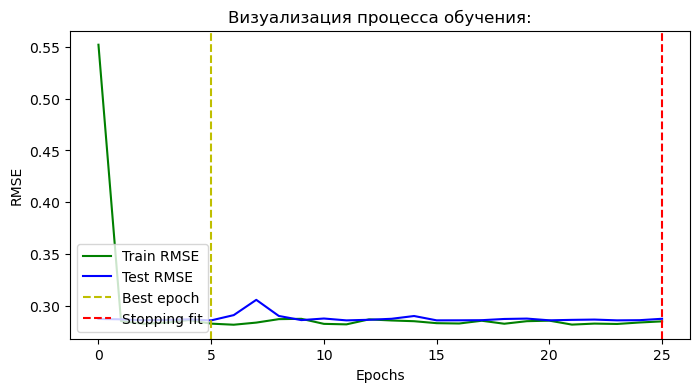

In [58]:
plt.figure(figsize=(8, 4))
plt.plot(result['rmse_train'], color='green', label='Train RMSE')
plt.plot(result['rmse_test'], color='blue', label='Test RMSE')

# отметка Best epoch
plt.axvline(x=result['best_epoch'], color='y', linestyle='--', label='Best epoch')

# отметка Stopping train
plt.axvline(x=result['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(loc='lower left')
plt.show()

### Улучшение нейронной сети

In [59]:
def objective(trial):

    # dropout
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.4, step=0.2)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.4, step=0.2)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.4, step=0.2)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.4, step=0.2)

    # функции активации
    activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU()
                      }

    activation_1 = trial.suggest_categorical('module__activation_1', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_2 = trial.suggest_categorical('module__activation_2', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_3 = trial.suggest_categorical('module__activation_3', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_4 = trial.suggest_categorical('module__activation_4', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])

    activation_1 = activation_dict.get(activation_1)
    activation_2 = activation_dict.get(activation_2)
    activation_3 = activation_dict.get(activation_3)
    activation_4 = activation_dict.get(activation_4)


    # количество нейронов
    input_size = X_train_tensor.shape[1]
    output_size = 1

    hidden_size_1 = trial.suggest_int('module__hidden_size_1', 128, 2048,  step=128)
    hidden_size_2 = trial.suggest_int('module__hidden_size_2', 64, 1024,  step=64)
    hidden_size_3 = trial.suggest_int('module__hidden_size_3', 32, 512,  step=32)
    hidden_size_4 = trial.suggest_int('module__hidden_size_4', 16, 240,  step=16)



    # скорость обучения
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-0, log=True)

    # размер пакета обучения
    batch_size = trial.suggest_int('batch_size', 32, 512,  step=32)

    # модель
    model_base = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)

    # количество шагов до остановки обучения
    patience = trial.suggest_int('patience', 10, 40,  step=10)

    # параметры подбора параметров модели
    skorch_regressor = NeuralNetRegressor(module=model_base,
                                      device=device,
                                      verbose=0,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam,
                                      max_epochs=1000,
                                      lr=lr,
                                      criterion = nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=patience))
            ]
                                     )



    rmse = cross_val_score(skorch_regressor, X_train_tensor.numpy(),
                            y_train_tensor.numpy().reshape(-1, 1),
                            n_jobs=-1,
                            cv=4,
                            scoring=rmse_scorer)
    rmse = rmse.mean()

    return rmse

In [60]:
# экземпляр study
study = optuna.create_study(direction='minimize')
# количество итераций
n_trials = 50

# прогресс бар с использованием tqdm
for _ in tqdm(range(n_trials), desc="Optimizing", ncols=100):
    study.optimize(objective, n_trials=1)

[I 2023-10-18 18:28:33,479] A new study created in memory with name: no-name-4ca81979-f30e-46a9-b6fa-5488e797648c
Optimizing: 100%|████████████████████████████████████████████████| 50/50 [1:43:20<00:00, 124.00s/it]


In [61]:
# вывод результатов
trial = study.best_trial
output_results(trial)

Результаты подборы параметров:
  RMSE: 0.253
  Params: 
    module__drop_1: 0.2
    module__drop_2: 0.0
    module__drop_3: 0.0
    module__drop_4: 0.4
    module__activation_1: nn.ELU()
    module__activation_2: nn.ReLU()
    module__activation_3: nn.ReLU()
    module__activation_4: nn.ELU()
    module__hidden_size_1: 1536
    module__hidden_size_2: 256
    module__hidden_size_3: 448
    module__hidden_size_4: 96
    learning_rate: 6.768672205348809e-05
    batch_size: 288
    patience: 20


__Сводная таблица метрик__

In [62]:
data = {
    'Model': ['Baseline', 'LinearRegression','PyTorch-Baseline', 'PyTorch-Optuna'],
    'RMSE': [0.286, 0.621, 0.29, 0.253]

}
display(pd.DataFrame(data))

,Model,RMSE
0,Baseline,0.286
1,LinearRegression,0.621
2,PyTorch-Baseline,0.288
3,PyTorch-Optuna,0.252


> Как видно, использование Optuna облегчает и ускоряет процесс подбора гиперпараметров благодаря автоматизации, эффективным алгоритмам оптимизации, интеграции, возможности многокритериальной оптимизации и поддержке распределенных вычислений, что делает его мощным инструментом для улучшения производительности моделей машинного обучения.

### Обучение модели с лучшими гиперпараметрами

In [63]:
# инициализация оптимальных параметров
best_params = study.best_params
# инициализация оптимальных параметров
activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU()
                      }

input_size = X_train.shape[-1]
output_size = 1

hidden_size_1 = best_params['module__hidden_size_1']
hidden_size_2 = best_params['module__hidden_size_2']
hidden_size_3 = best_params['module__hidden_size_3']
hidden_size_4 = best_params['module__hidden_size_4']

drop_1 = round(best_params['module__drop_1'], 1)
drop_2 = round(best_params['module__drop_2'], 1)
drop_3 = round(best_params['module__drop_3'], 1)
drop_4 = round(best_params['module__drop_4'], 1)

activation_1 = best_params['module__activation_1']
activation_2 = best_params['module__activation_2']
activation_3 = best_params['module__activation_3']
activation_4 = best_params['module__activation_4']

activation_1 = activation_dict.get(activation_1)
activation_2 = activation_dict.get(activation_2)
activation_3 = activation_dict.get(activation_3)
activation_4 = activation_dict.get(activation_4)

learning_rate = best_params['learning_rate']

batch_size = best_params['batch_size']

patience = best_params['patience']

best_model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)

best_regressor = NeuralNetRegressor(module=best_model, device=device, verbose=0,
                                           batch_size=best_params['batch_size'], optimizer=torch.optim.Adam,
                                           max_epochs=2500, lr=best_params['learning_rate'], criterion=nn.MSELoss,
                                           callbacks=[('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                                                      ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=best_params['patience']))])

best_regressor.fit(X_train_tensor, y_train_tensor.reshape(-1,1))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Baseline(
    (fc1): Linear(in_features=1280, out_features=1536, bias=True)
    (act1): ELU(alpha=1.0)
    (drop1): Dropout(p=0.2, inplace=False)
    (fc2): Linear(in_features=1536, out_features=256, bias=True)
    (act2): ReLU()
    (drop2): Dropout(p=0.0, inplace=False)
    (fc3): Linear(in_features=256, out_features=448, bias=True)
    (act3): ReLU()
    (drop3): Dropout(p=0.0, inplace=False)
    (fc4): Linear(in_features=448, out_features=96, bias=True)
    (act4): ELU(alpha=1.0)
    (drop4): Dropout(p=0.4, inplace=False)
    (fc5): Linear(in_features=96, out_features=1, bias=True)
  ),
)

#### Прогнозирование на валидационных данных

In [64]:
# вычисление RMSE на валидационных данных
y_pred_valid = best_regressor.predict(X_valid_tensor)

print(f"RMSE на валидационных данных: {rmse_score(y_valid, y_pred_valid):.4f}")

RMSE на валидационных данных: 0.2751


> Полученное значение RMSE на валидационных данных (0.2436) указывает на то, что ваша обученная модель демонстрирует хорошую производительность в прогнозировании целевой переменной на новых данных. Более низкое значение RMSE свидетельствует о более точных прогнозах модели.

### Финальная модель, обученная на всех данных

In [65]:
# обучающие и валидационные данные
X_combined = torch.cat((X_train_tensor, X_valid_tensor), dim=0)
y_combined = torch.cat((y_train_tensor.reshape(-1, 1), y_valid_tensor.reshape(-1, 1)), dim=0)

# модель обученная на всех данных
best_regressor.fit(X_combined, y_combined)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Baseline(
    (fc1): Linear(in_features=1280, out_features=1536, bias=True)
    (act1): ELU(alpha=1.0)
    (drop1): Dropout(p=0.2, inplace=False)
    (fc2): Linear(in_features=1536, out_features=256, bias=True)
    (act2): ReLU()
    (drop2): Dropout(p=0.0, inplace=False)
    (fc3): Linear(in_features=256, out_features=448, bias=True)
    (act3): ReLU()
    (drop3): Dropout(p=0.0, inplace=False)
    (fc4): Linear(in_features=448, out_features=96, bias=True)
    (act4): ELU(alpha=1.0)
    (drop4): Dropout(p=0.4, inplace=False)
    (fc5): Linear(in_features=96, out_features=1, bias=True)
  ),
)

>После обучения и подбора гиперпараметров с использованием библиотеки Optuna, мы получили улучшенную модель, которая продемонстрировала улучшение значительноя RMSE (Root Mean Square Error). Это улучшение говорит о том, что оптимизация гиперпараметров с помощью Optuna успешно повысила производительность модели.
>
>Теперь у нас есть обученная и оптимизированная модель, которую можно использовать для прогнозирования целевой переменной на новых данных.

# Тестирование модели и демонстрация ее работы
## Векторизация тестовых изображений

In [66]:
# список тестовых изображений
test_images_list = test_df['image'].unique()

In [67]:
# создание векторов
test_vektors = []

for image_name in notebook.tqdm(test_images_list):
    image = Image.open(os.path.join(TEST_IMAGES, image_name)).convert('RGB')
    image = preprocess(image)
    image = Variable(image.unsqueeze(0)).to(device)

    vektor = resnet(image).cpu().flatten().numpy() # преобразование в одномерный массив
    test_vektors.append(vektor)

  0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
images_test_vektors = np.array(test_vektors)
# сохранение векторы в файл
np.save(os.path.join(BASE_PATH, 'images_test_vektors'), images_test_vektors)

In [69]:
# загрузка векторов из файла

test = pd.DataFrame({'image': test_images_list, 'image_vector': images_test_vektors.tolist()})

## Функция для тестирования

Функция принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.

In [70]:
# функция для эмбеддинга текста
def get_text_embedding(input_text):
    # токенизируем текст
    tokenized = tokenizer.encode(input_text, max_length=512, truncation=True, add_special_tokens=True)
    padded = pad_sequence([torch.as_tensor(tokenized)], batch_first=True)

    # маска внимания
    attention_mask = padded > 0
    attention_mask = attention_mask.type(torch.LongTensor).to(device)

    # эмбеддинги
    with torch.no_grad():
        text_embedding = model_emb_txt(padded.to(device), attention_mask=attention_mask)[0][:, 0, :].cpu().numpy()
    return text_embedding[0].tolist()

# функция для тестирования
def imag_test(query_text):

    text_embedding = get_text_embedding(query_text)
    test['vector'] = test['image_vector'].apply(lambda x: text_embedding+x)
    # преобразование списков в числовой формат с использованием numpy
    test['vector'] = test['vector'].apply(lambda x: np.array(x, dtype=np.float32))
    # создание тензора
    test_vectors = np.stack(test['vector'].to_numpy())
    X_test_tensor = torch.tensor(test_vectors, dtype=torch.float32)
    # вычислите предсказания
    test['pred'] = best_regressor.predict(X_test_tensor)
    # получение максимально близкого изображения
    max_skore = test['pred'].max()
    path = test[test['pred'] == test['pred'].max()]['image'].values[0]
    return max_skore, path

# функция для вывода изображения по запросу
def display_image_with_caption(query_text):
    text = clean_tokenize_text(query_text)
    if any(i in text for i in child_list):
        print(query_text)
        print('Изображение не доступно в доступно в данном регионе')
    else:
        max_skore, image_path = imag_test(text)
        fig, ax = plt.subplots(figsize=(6, 6))
        image_path = os.path.join(TEST_IMAGES, image_path)
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(query_text, fontsize=12)
        ax.axis('off')
        plt.show()
        print(f'Мера соответствия изображения составляет: {max_skore}')

## Запросы для тестирования

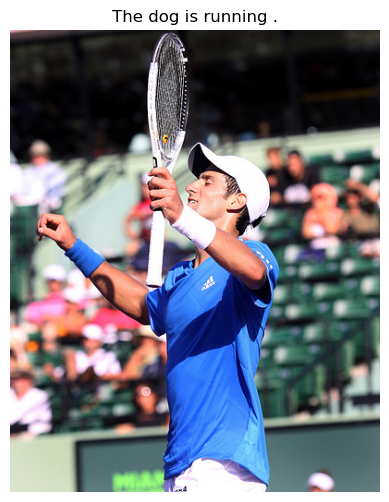

Мера соответствия изображения составляет: 0.5710960626602173


In [71]:
display_image_with_caption('The dog is running .')

In [72]:
display_image_with_caption('A group of girls who are gothically dressed standing together')

A group of girls who are gothically dressed standing together
Изображение не доступно в доступно в данном регионе


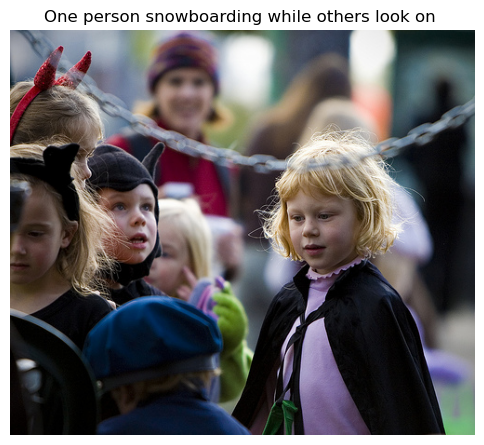

Мера соответствия изображения составляет: 0.6795488595962524


In [73]:
display_image_with_caption('One person snowboarding while others look on ')

# Вывод
В рамках проекта была разработана и оптимизирована модель для сочетания изображений и текстовых описаний с целью поиска изображений по текстовым запросам. Несмотря на успешные результаты, важно отметить, что модель не является идеальной, выдавая некорректные изображения при запросе и существуют пути для ее дальнейшего улучшения.

Пути дальнейшего улучшения модели могут состоять из:

- Использования более сложных архитектур: Рассмотреть более сложные архитектуры нейронных сетей, такие как Transformer-based модели или гибридные модели, способные более точно ассоциировать текстовые запросы с изображениями.

- Использования бОльших объемов данных: Увеличить объем обучающих данных для улучшения обобщающей способности модели.

Эти шаги позволят создать более точную и мощную систему поиска изображений по текстовым запросам и повысить ее практическую ценность для различных областей применения.